In [1]:
import typing
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import io
import urllib.request
import urllib.parse
import validators
import matplotlib.pyplot as plt
from shapely import geometry
from scipy import spatial
from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, Activation, MaxPooling2D

In [2]:
def read(filepath_or_buffer: typing.Union[str, io.BytesIO, np.ndarray]):
    if isinstance(filepath_or_buffer, np.ndarray):
        return filepath_or_buffer

    if hasattr(filepath_or_buffer, "read"):
        image_data = _read_from_buffer(filepath_or_buffer)
    elif isinstance(filepath_or_buffer, str):
        image_data = _read_from_file_or_url(filepath_or_buffer)

    return cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)


def _read_from_buffer(buffer: io.BytesIO) -> np.ndarray:
    image_data = np.asarray(bytearray(buffer.read()), dtype=np.uint8)
    return cv2.imdecode(image_data, cv2.IMREAD_UNCHANGED)


def _read_from_file_or_url(filepath_or_url: str) -> np.ndarray:
    if validators.url(filepath_or_url):
        with urllib.request.urlopen(filepath_or_url) as response:
            return _read_from_buffer(io.BytesIO(response.read()))

    assert os.path.isfile(filepath_or_url), (
        "Could not find image_data at path: " + filepath_or_url
    )
    return cv2.imread(filepath_or_url)


def drawBoxes(image, boxes, color=(255, 0, 0), thickness=5, boxes_format="boxes"):
    if len(boxes) == 0:
        return image
    canvas = image.copy()
    if boxes_format == "lines":
        revised_boxes = []
        for line in boxes:
            for box, _ in line:
                revised_boxes.append(box)
        boxes = revised_boxes
    if boxes_format == "predictions":
        revised_boxes = []
        for _, box in boxes:
            revised_boxes.append(box)
        boxes = revised_boxes
    for box in boxes:
        cv2.polylines(
            img=canvas,
            pts=box[np.newaxis].astype("int32"),
            color=color,
            thickness=thickness,
            isClosed=True,
        )
    return canvas


def get_rotated_box(
    points,
) -> typing.Tuple[np.ndarray, float,]:
    try:
        mp = geometry.MultiPoint(points=points)
        pts = np.array(list(zip(*mp.minimum_rotated_rectangle.exterior.xy)))[
            :-1
        ]  # noqa: E501
    except AttributeError:
        # There weren't enough points for the minimum rotated rectangle function
        pts = points

    xSorted = pts[np.argsort(pts[:, 0]), :]

    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    D = spatial.distance.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    pts = np.array([tl, tr, br, bl], dtype="float32")

    rotation = np.arctan((tl[0] - bl[0]) / (tl[1] - bl[1]))
    return pts, rotation


def fix_line(line):
    line = [(get_rotated_box(box)[0], character) for box, character in line]
    centers = np.array([box.mean(axis=0) for box, _ in line])
    sortedx = centers[:, 0].argsort()
    sortedy = centers[:, 1].argsort()
    if np.diff(centers[sortedy][:, 1]).sum() > np.diff(centers[sortedx][:, 0]).sum():
        return [line[idx] for idx in sortedy], "vertical"
    return [line[idx] for idx in sortedx], "horizontal"


def compute_input(image):
    image = image.astype("float32")
    mean = np.array([0.485, 0.456, 0.406])
    variance = np.array([0.229, 0.224, 0.225])

    image -= mean * 255
    image /= variance * 255
    return image


def upconv(x, n, filters):
    x = keras.layers.Conv2D(
        filters=filters, kernel_size=1, strides=1, name=f"upconv{n}.conv.0"
    )(x)
    x = keras.layers.BatchNormalization(
        epsilon=1e-5, momentum=0.9, name=f"upconv{n}.conv.1"
    )(x)
    x = keras.layers.Activation("relu", name=f"upconv{n}.conv.2")(x)
    x = keras.layers.Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=1,
        padding="same",
        name=f"upconv{n}.conv.3",
    )(x)
    x = keras.layers.BatchNormalization(
        epsilon=1e-5, momentum=0.9, name=f"upconv{n}.conv.4"
    )(x)
    x = keras.layers.Activation("relu", name=f"upconv{n}.conv.5")(x)
    return x


def make_vgg_block(x, filters, n, prefix, pooling=True):
    x = keras.layers.Conv2D(
        filters=filters,
        strides=(1, 1),
        kernel_size=(3, 3),
        padding="same",
        name=f"{prefix}.{n}",
    )(x)
    x = keras.layers.BatchNormalization(
        momentum=0.1, epsilon=1e-5, axis=-1, name=f"{prefix}.{n+1}"
    )(x)
    x = keras.layers.Activation("relu", name=f"{prefix}.{n+2}")(x)
    if pooling:
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2), padding="valid", strides=(2, 2), name=f"{prefix}.{n+3}"
        )(x)
    return x


def getBoxes(
    y_pred,
    detection_threshold=0.7,
    text_threshold=0.4,
    link_threshold=0.4,
    size_threshold=10,
):
    box_groups = []
    for y_pred_cur in y_pred:
        # Prepare data
        textmap = y_pred_cur[..., 0].copy()
        linkmap = y_pred_cur[..., 1].copy()
        img_h, img_w = textmap.shape

        _, text_score = cv2.threshold(
            textmap, thresh=text_threshold, maxval=1, type=cv2.THRESH_BINARY
        )
        _, link_score = cv2.threshold(
            linkmap, thresh=link_threshold, maxval=1, type=cv2.THRESH_BINARY
        )
        n_components, labels, stats, _ = cv2.connectedComponentsWithStats(
            np.clip(text_score + link_score, 0, 1).astype("uint8"), connectivity=4
        )
        boxes = []
        for component_id in range(1, n_components):
            # Filter by size
            size = stats[component_id, cv2.CC_STAT_AREA]

            if size < size_threshold:
                continue

            # If the maximum value within this connected component is less than
            # text threshold, we skip it.
            if np.max(textmap[labels == component_id]) < detection_threshold:
                continue

            # Make segmentation map. It is 255 where we find text, 0 otherwise.
            segmap = np.zeros_like(textmap)
            segmap[labels == component_id] = 255
            segmap[np.logical_and(link_score, text_score)] = 0
            x, y, w, h = [
                stats[component_id, key]
                for key in [
                    cv2.CC_STAT_LEFT,
                    cv2.CC_STAT_TOP,
                    cv2.CC_STAT_WIDTH,
                    cv2.CC_STAT_HEIGHT,
                ]
            ]

            # Expand the elements of the segmentation map
            niter = int(np.sqrt(size * min(w, h) / (w * h)) * 2)
            sx, sy = max(x - niter, 0), max(y - niter, 0)
            ex, ey = min(x + w + niter + 1, img_w), min(y + h + niter + 1, img_h)
            segmap[sy:ey, sx:ex] = cv2.dilate(
                segmap[sy:ey, sx:ex],
                cv2.getStructuringElement(cv2.MORPH_RECT, (1 + niter, 1 + niter)),
            )

            # Make rotated box from contour
            contours = cv2.findContours(
                segmap.astype("uint8"),
                mode=cv2.RETR_TREE,
                method=cv2.CHAIN_APPROX_SIMPLE,
            )[-2]
            contour = contours[0]
            box = cv2.boxPoints(cv2.minAreaRect(contour))

            # Check to see if we have a diamond
            w, h = np.linalg.norm(box[0] - box[1]), np.linalg.norm(box[1] - box[2])
            box_ratio = max(w, h) / (min(w, h) + 1e-5)
            if abs(1 - box_ratio) <= 0.1:
                l, r = contour[:, 0, 0].min(), contour[:, 0, 0].max()
                t, b = contour[:, 0, 1].min(), contour[:, 0, 1].max()
                box = np.array([[l, t], [r, t], [r, b], [l, b]], dtype=np.float32)
            else:
                # Make clock-wise order
                box = np.array(np.roll(box, 4 - box.sum(axis=1).argmin(), 0))
            boxes.append(2 * box)
        box_groups.append(np.array(boxes))
    return box_groups


class UpsampleLike(keras.layers.Layer):
    def call(self, inputs, **kwargs):
        source, target = inputs
        target_shape = keras.backend.shape(target)

        if keras.backend.image_data_format() == "channels_first":
            raise NotImplementedError(
                "UpsampleLike layer not implemented for channels_first format."
            )
        else:
            resized_source = tf.compat.v1.image.resize_bilinear(
                source, size=(target_shape[1], target_shape[2]), half_pixel_centers=True
            )
            return resized_source

    def compute_output_shape(self, input_shape):
        if keras.backend.image_data_format() == "channels_first":
            raise NotImplementedError(
                "UpsampleLike layer not implemented for channels_first format."
            )
        else:
            return (input_shape[0][0],) + input_shape[1][1:3] + (input_shape[0][-1],)


def build_vgg_backbone(inputs):
    x = make_vgg_block(inputs, filters=64, n=0, pooling=False, prefix="basenet.slice1")
    x = make_vgg_block(x, filters=64, n=3, pooling=True, prefix="basenet.slice1")
    x = make_vgg_block(x, filters=128, n=7, pooling=False, prefix="basenet.slice1")
    x = make_vgg_block(x, filters=128, n=10, pooling=True, prefix="basenet.slice1")
    x = make_vgg_block(x, filters=256, n=14, pooling=False, prefix="basenet.slice2")
    x = make_vgg_block(x, filters=256, n=17, pooling=False, prefix="basenet.slice2")
    x = make_vgg_block(x, filters=256, n=20, pooling=True, prefix="basenet.slice3")
    x = make_vgg_block(x, filters=512, n=24, pooling=False, prefix="basenet.slice3")
    x = make_vgg_block(x, filters=512, n=27, pooling=False, prefix="basenet.slice3")
    x = make_vgg_block(x, filters=512, n=30, pooling=True, prefix="basenet.slice4")
    x = make_vgg_block(x, filters=512, n=34, pooling=False, prefix="basenet.slice4")
    x = make_vgg_block(x, filters=512, n=37, pooling=False, prefix="basenet.slice4")
    x = make_vgg_block(x, filters=512, n=40, pooling=True, prefix="basenet.slice4")
    vgg = keras.models.Model(inputs=inputs, outputs=x)
    return [
        vgg.get_layer(slice_name).output
        for slice_name in [
            "basenet.slice1.12",
            "basenet.slice2.19",
            "basenet.slice3.29",
            "basenet.slice4.38",
        ]
    ]


def build_keras_model(weights_path: str = None, backbone_name="vgg"):
    inputs = Input((None, None, 3))

    if backbone_name == "vgg":
        s1, s2, s3, s4 = build_vgg_backbone(inputs)
    else:
        raise NotImplementedError(f"Unsupported backbone: {backbone_name}")

    s5 = MaxPooling2D(pool_size=3, strides=1, padding="same", name="basenet.slice5.0")(
        s4
    )
    s5 = Conv2D(
        1024,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        dilation_rate=6,
        name="basenet.slice5.1",
    )(s5)
    s5 = Conv2D(
        1024, kernel_size=1, strides=1, padding="same", name="basenet.slice5.2"
    )(s5)

    y = Concatenate()([s5, s4])
    y = upconv(y, n=1, filters=512)
    y = UpsampleLike()([y, s3])
    y = Concatenate()([y, s3])
    y = upconv(y, n=2, filters=256)
    y = UpsampleLike()([y, s2])
    y = Concatenate()([y, s2])
    y = upconv(y, n=3, filters=128)
    y = UpsampleLike()([y, s1])
    y = Concatenate()([y, s1])
    features = upconv(y, n=4, filters=64)

    y = Conv2D(filters=32, kernel_size=3, strides=1, padding="same", name="conv_cls.0")(
        features
    )
    y = Activation("relu", name="conv_cls.1")(y)
    y = Conv2D(filters=32, kernel_size=3, strides=1, padding="same", name="conv_cls.2")(
        y
    )
    y = Activation("relu", name="conv_cls.3")(y)
    y = Conv2D(filters=16, kernel_size=3, strides=1, padding="same", name="conv_cls.4")(
        y
    )
    y = Activation("relu", name="conv_cls.5")(y)
    y = Conv2D(filters=16, kernel_size=1, strides=1, padding="same", name="conv_cls.6")(
        y
    )
    y = Activation("relu", name="conv_cls.7")(y)
    y = Conv2D(filters=2, kernel_size=1, strides=1, padding="same", name="conv_cls.8")(
        y
    )

    model = Model(inputs=inputs, outputs=y)

    if weights_path is not None and weights_path.endswith(".h5"):
        model.load_weights(weights_path)
    elif weights_path is not None:
        raise NotImplementedError(f"Cannot load weights from {weights_path}")

    return model


class Detector:
    def __init__(
        self,
        weights="craft_mlt_25k.h5",
        optimizer="adam",
        backbone_name="vgg",
    ):
        assert backbone_name == "vgg", "Pretrained weights available only for VGG."

        self.model = build_keras_model(
            weights_path=weights, backbone_name=backbone_name
        )
        self.model.compile(loss="mse", optimizer=optimizer)

    def detect(
        self,
        images: typing.List[typing.Union[np.ndarray, str]],
        detection_threshold=0.7,
        text_threshold=0.4,
        link_threshold=0.4,
        size_threshold=10,
        **kwargs,
    ):
        images = [compute_input(read(image)) for image in images]
        boxes = getBoxes(
            self.model.predict(np.array(images), **kwargs),
            detection_threshold=detection_threshold,
            text_threshold=text_threshold,
            link_threshold=link_threshold,
            size_threshold=size_threshold,
        )
        return boxes




In [14]:
# Function to crop and display images for each detected box
def display_cropped_images(image, boxes, padding=5):
    for i, box in enumerate(boxes):
        # Extract coordinates of the box
        xmin, ymin = np.min(box, axis=0)
        xmax, ymax = np.max(box, axis=0)

        # Add padding to the box
        xmin, ymin = max(0, int(xmin) - padding), max(0, int(ymin) - padding)
        xmax, ymax = min(image.shape[1], int(xmax) + padding), min(image.shape[0], int(ymax) + padding)

        # Crop the image
        cropped_image = image[ymin:ymax, xmin:xmax]

        # Display the cropped image in a separate window
        plt.figure()
        plt.imshow(cropped_image)
        plt.title(f"Box {i + 1}")
        plt.axis("off")
        plt.show()


1/1 [==============================] - 2s 2s/step


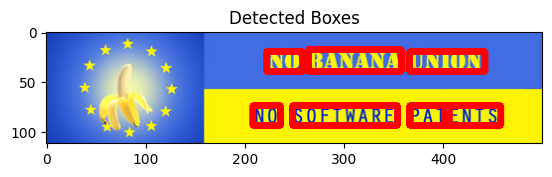

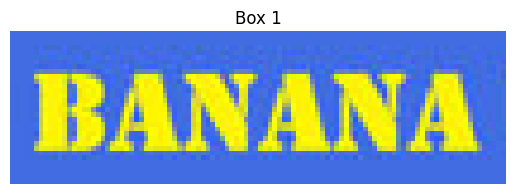

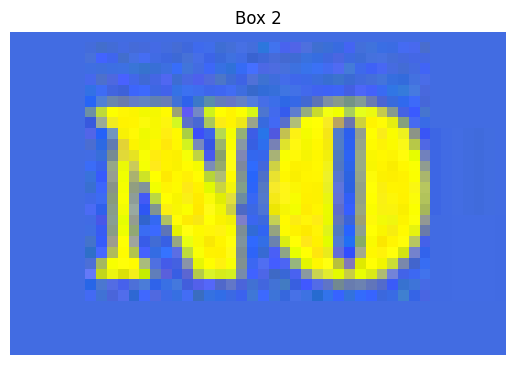

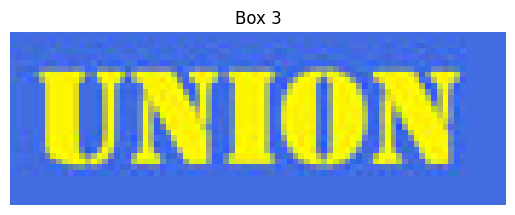

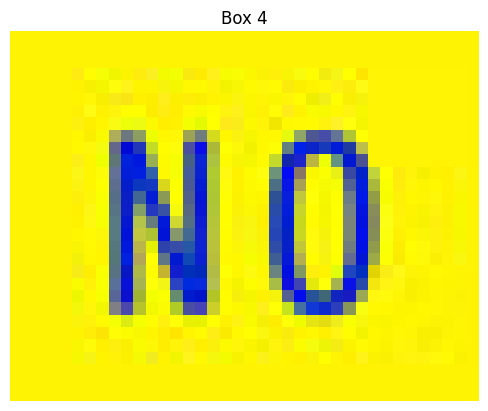

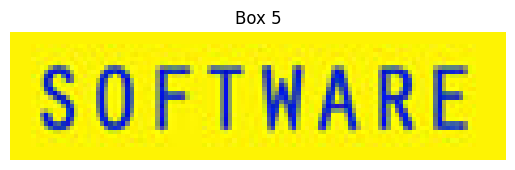

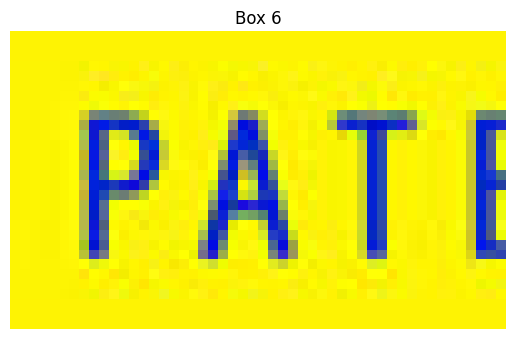

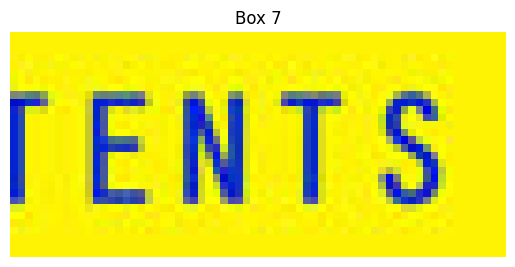

In [24]:
# Instantiate the Detector class with your desired configuration
detector = Detector(weights="craft_mlt_25k.h5", backbone_name="vgg")
# Example: Load a single image for inference (replace with your image loading logic)
image_path = "EUBanana-500x112.jpg"
image = read(
    image_path
)  # Assuming 'read' is the function to load and preprocess images

# Example: Perform detection on the single image
detected_boxes = detector.detect([image])
img_with_boxes = drawBoxes(image.copy(), detected_boxes[0])
plt.imshow(img_with_boxes)
plt.title("Detected Boxes")
plt.show()
display_cropped_images(image, detected_boxes[0])
